# MONTAGEM DO DRIVE E IMPORTS NECESSÁRIOS AO PROJETO

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#A distribuição dos dados em cada uma das classes de informação
#Normal	Actionable	Benign	Cancer
#[81, 59, 54, 39]

#https://arxiv.org/ftp/arxiv/papers/2004/2004.00218.pdf //paper sobre a história e desenvolvimento de redes neurais na área médica.
#Data augmentation

#possibilidades de preprocessamento: 
"""
(1) artifact removal,
(2) normalization, 
(3) slice timing correction (STC), ***
(4) image registration and  ****
(5) bias field correction
"""

#página 284 hands on - droput de monte carlo para predição
#diferentes variantes da relu
#diferentes forma de mudança do learning rate

#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6188511/
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6539746/
#https://www.researchgate.net/publication/316244066_3D_fully_convolutional_networks_for_subcortical_segmentation_in_MRI_A_large-scale_study
#https://www.semanticscholar.org/reader/fba7365aa45df49fa86d4b678d4a3164a11cf19c



'\n(1) artifact removal,\n(2) normalization, \n(3) slice timing correction (STC), ***\n(4) image registration and  ****\n(5) bias field correction\n'

In [3]:
!pip install pydicom

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [ ]:
!pip install pydicom
import pydicom

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import ndimage
import cv2
from gc import collect
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
#import xgboost as xgb
#import pydicom
import seaborn
import cv2
from sklearn.utils import shuffle

# FUNÇÕES PARA LER E PROCESSAR OS DADOS ANTES DE SEREM UTILIZADOS NOS MODELOS

In [2]:
def get_labels(label_file):
    """lê a tabela com as informações dos pacientes e retorna uma matriz com o ID e as labels"""
    labels = pd.read_csv(label_file)
    cancer_labels = dict()

    for p in labels.index:
        cancer_labels[labels['PatientID'][p]] = [int(labels['Normal'][p]), int(labels['Actionable'][p]), int(labels['Benign'][p]), int(labels['Cancer'][p])]

    return cancer_labels

In [3]:
labels = get_labels('/kaggle/input/usar-esses-aqui/labels.csv')

In [6]:
print(list(labels.keys()))

['DBT-P00013', 'DBT-P00023', 'DBT-P00024', 'DBT-P00060', 'DBT-P00107', 'DBT-P00183', 'DBT-P00194', 'DBT-P00296', 'DBT-P00303', 'DBT-P00361', 'DBT-P00488', 'DBT-P00538', 'DBT-P00583', 'DBT-P00654', 'DBT-P00661', 'DBT-P00684', 'DBT-P00688', 'DBT-P00710', 'DBT-P00754', 'DBT-P00784', 'DBT-P00785', 'DBT-P00818', 'DBT-P00827', 'DBT-P00869', 'DBT-P00890', 'DBT-P00892', 'DBT-P00910', 'DBT-P01027', 'DBT-P01054', 'DBT-P01106', 'DBT-P01110', 'DBT-P01112', 'DBT-P01130', 'DBT-P01139', 'DBT-P01157', 'DBT-P01181', 'DBT-P01202', 'DBT-P01211', 'DBT-P01241', 'DBT-P01262', 'DBT-P01267', 'DBT-P01282', 'DBT-P01347', 'DBT-P01388', 'DBT-P01461', 'DBT-P01485', 'DBT-P01488', 'DBT-P01493', 'DBT-P01539', 'DBT-P01624', 'DBT-P01626', 'DBT-P01632', 'DBT-P01673', 'DBT-P01712', 'DBT-P01718', 'DBT-P01745', 'DBT-P01751', 'DBT-P01753', 'DBT-P01760', 'DBT-P01761', 'DBT-P01796', 'DBT-P01801', 'DBT-P01817', 'DBT-P01822', 'DBT-P01826', 'DBT-P01839', 'DBT-P01973', 'DBT-P01978', 'DBT-P01999', 'DBT-P02065', 'DBT-P02100', 'DBT-

In [3]:
def read_dataset(features_pathfile, csv_labels_pathfile, images_per_class):
  """
      A partir de um conjunto de numpy arrays salvos e do csv com as 
  labels, será montado o conjunto de dados para uso nos algoritmos com um 
  número máximo de features por classe. 
  ********(função com possível modificação no futuro)********
  """
  examples_per_class = [0, 0, 0, 0]

  pacients_ID = os.listdir(features_pathfile)
  labels_list = get_labels(csv_labels_pathfile)
  X, y = [], []
  for ID in pacients_ID:
    if ID == 'labels.csv':
        continue
        
    label = labels_list[ID[:-4]]

    if images_per_class != -1:
        if examples_per_class[np.argmax(label)] > images_per_class:
            continue

        examples_per_class[np.argmax(label)] += 1
        X.append(np.load(features_pathfile + '/' + ID))

        if len(y) == images_per_class*4:
            break
    else:
        X.append(np.load(features_pathfile + '/' + ID))

    y.append(label)

  collect()
  return np.array(X, dtype='float16'), np.array(y, dtype='float16')


In [4]:
X, y = read_dataset('/kaggle/input/usar-esses-aqui', 
                    '/kaggle/input/usar-esses-aqui/labels.csv', -1)

In [18]:
img = np.array(X[0,:,:,5])
img.shape

(175, 260, 1)

In [22]:
img = np.array(X[0,:,:,5])
kernel = np.ones((5,5), np.uint8) 
  
img_erosion = cv2.erode(img, kernel, iterations=1) 
img_dilation = cv2.dilate(img, kernel, iterations=1) 
  
cv2.imshow('Input', img) 
cv2.imshow('Erosion', img_erosion) 
cv2.imshow('Dilation', img_dilation) 

error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'subtract'
> Overload resolution failed:
>  - src1 data type = 23 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src1'


In [5]:
train_x, train_y = np.empty((152, 175, 260, 10, 1), dtype='float32'), np.empty((152, 4), dtype='int8')
val_x, val_y = np.empty((40, 175, 260, 10, 1), dtype='float32'), np.empty((40, 4), dtype='int8')
test_x, test_y = np.empty((40, 175, 260, 10, 1), dtype='float32'), np.empty((40, 4), dtype='int8')
counter = np.zeros((2, 4))

X, y = shuffle(X, y, random_state=437843)

In [60]:
val_x.shape

(40, 175, 260, 10, 1)

In [61]:
counter

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [62]:
count_train = 0
count_val = 0
count_test = 0

for i, j in zip(X, y):
    if counter[0][np.argmax(j)] < 10:
        val_x[count_val] = i
        val_y[count_val] = j
        counter[0][np.argmax(j)] += 1
        count_val += 1
    elif counter[1][np.argmax(j)] < 10:
        test_x[count_test] = i
        test_y[count_test] = j
        counter[1][np.argmax(j)] += 1
        count_test += 1
    else:
        train_x[count_train] = i
        train_y[count_train] = j
        count_train += 1

# UTILIZAÇÃO DAS FUNÇÕES PARA CRIAR E SEPARAR O DATASET PARA USO NAS NNs

In [4]:
X, y = read_dataset('/kaggle/input/usar-esses-aqui', 
                    '/kaggle/input/usar-esses-aqui/labels.csv', -1)


dataset_length = len(X)

X, y = shuffle(X, y, random_state=437843)

train_x, train_y = X[0:int(dataset_length*0.52)], y[0:int(dataset_length*0.52)]
val_x, val_y = X[int(dataset_length*0.52):int(dataset_length*0.71)], y[int(dataset_length*0.52):int(dataset_length*0.71)]
test_x, test_y = X[int(dataset_length*0.71):], y[int(dataset_length*0.71):]

train_x.shape, val_x.shape, test_x.shape, train_y.shape, val_y.shape, test_y.shape

((120, 175, 260, 10, 1),
 (44, 175, 260, 10, 1),
 (68, 175, 260, 10, 1),
 (120, 4),
 (44, 4),
 (68, 4))

In [5]:
del X
del y

In [6]:
#data augmentation part 1
new_data = []

for x in train_x:
    x = np.squeeze(x, -1)
    x = x.astype(dtype='float32')
    x = cv2.flip(x, 1)
    new_data.append(np.expand_dims(x, -1).astype('float16'))

new_data = np.array(new_data)
train_x = np.concatenate((train_x, new_data))
train_y = np.concatenate((train_y, train_y))
del new_data
collect()

46

In [7]:
#data augmentation part 2
i = 0
j = 0
random.seed(43859)
for x, y in zip(train_x, train_y):
    if np.argmax(y) == 0 and random.random() > 0.667:
        continue
        
    x = x.astype('float32')
    img = ndimage.rotate(np.squeeze(x,-1), angle=15, axes=(1, 0), reshape=False)
    img = np.expand_dims(np.expand_dims(img, -1), 0)
    img = img.astype('float16')
    train_x = np.concatenate((train_x, img))
    
    x = x.astype('float32')
    img = ndimage.rotate(np.squeeze(x,-1), angle=-15, axes=(1, 0), reshape=False)
    img = np.expand_dims(np.expand_dims(img, -1), 0)
    img = img.astype('float16')
    train_x = np.concatenate((train_x, img))
    train_y = np.concatenate((train_y, np.expand_dims(train_y[j], 0), np.expand_dims(train_y[j], 0)))
    
    i += 2
    j += 1

    collect()

In [8]:
train_x.shape, val_x.shape, test_x.shape

((684, 175, 260, 10, 1), (44, 175, 260, 10, 1), (68, 175, 260, 10, 1))

In [9]:
del img
del i
del j
del dataset_length
collect()

46

In [10]:
#callback para salvar o modelo posteriormente
checkpoint_callback_accuracy = keras.callbacks.ModelCheckpoint(filepath='./models/accuracy/',
                                                                  save_weights_only=True,
                                                                  monitor='val_categorical_accuracy',
                                                                  mode='max',
                                                                  save_best_only=True)

checkpoint_callback_precision = keras.callbacks.ModelCheckpoint(filepath='./models/precision/',
                                                                   save_weights_only=True,
                                                                   monitor='val_precision',
                                                                   mode='max',
                                                                   save_best_only=True)

checkpoint_callback_auc1 = keras.callbacks.ModelCheckpoint(filepath='./models/auc1/',
                                                             save_weights_only=True,
                                                             monitor='val_auc',
                                                             mode='max',
                                                             save_best_only=True)

checkpoint_callback_auc2 = keras.callbacks.ModelCheckpoint(filepath='./models/auc2/',
                                                             save_weights_only=True,
                                                             monitor='val_auc_1',
                                                             mode='max',
                                                             save_best_only=True)

In [11]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [11]:
#https://www.researchgate.net/publication/316244066_3D_fully_convolutional_networks_for_subcortical_segmentation_in_MRI_A_large-scale_study

model_test1 = tf.keras.Sequential()

model_test1.add(tf.keras.layers.Conv3D(input_shape=(175,260,10,1), filters=16, kernel_size=(8,12,5), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=16, kernel_size=(3,3,3), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)))
model_test1.add(tf.keras.layers.Conv3D(filters=32, kernel_size=(3,3,3), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=32, kernel_size=(3,3,3), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=64, kernel_size=(3,3,2), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=64, kernel_size=(3,3,2), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=128, kernel_size=(3,3,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=128, kernel_size=(3,3,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,1)))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=256, kernel_size=(3,3,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=256, kernel_size=(3,3,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,1)))
model_test1.add(tf.keras.layers.Conv3D(filters=512, kernel_size=(3,3,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=512, kernel_size=(3,3,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,1)))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=1024, kernel_size=(2,3,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=1024, kernel_size=(2,3,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.MaxPooling3D(pool_size=(2,4,1)))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Flatten())
model_test1.add(tf.keras.layers.Dense(4, activation=('softmax')))

model_test1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, amsgrad=True), 
                    loss='categorical_crossentropy', 
                    metrics=[tf.keras.metrics.CategoricalAccuracy(), 
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.AUC(multi_label=True, num_labels=4, label_weights=[0.25, 0.5, 0.25, 1]),
                             tf.keras.metrics.AUC(multi_label=True, num_labels=4)])

model_test1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 175, 260, 10, 16)  7696      
                                                                 
 batch_normalization_24 (Bat  (None, 175, 260, 10, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_23 (Conv3D)          (None, 175, 260, 10, 16)  6928      
                                                                 
 batch_normalization_25 (Bat  (None, 175, 260, 10, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 87, 130, 5, 16)   0         
 g3D)                                                            
                                                      

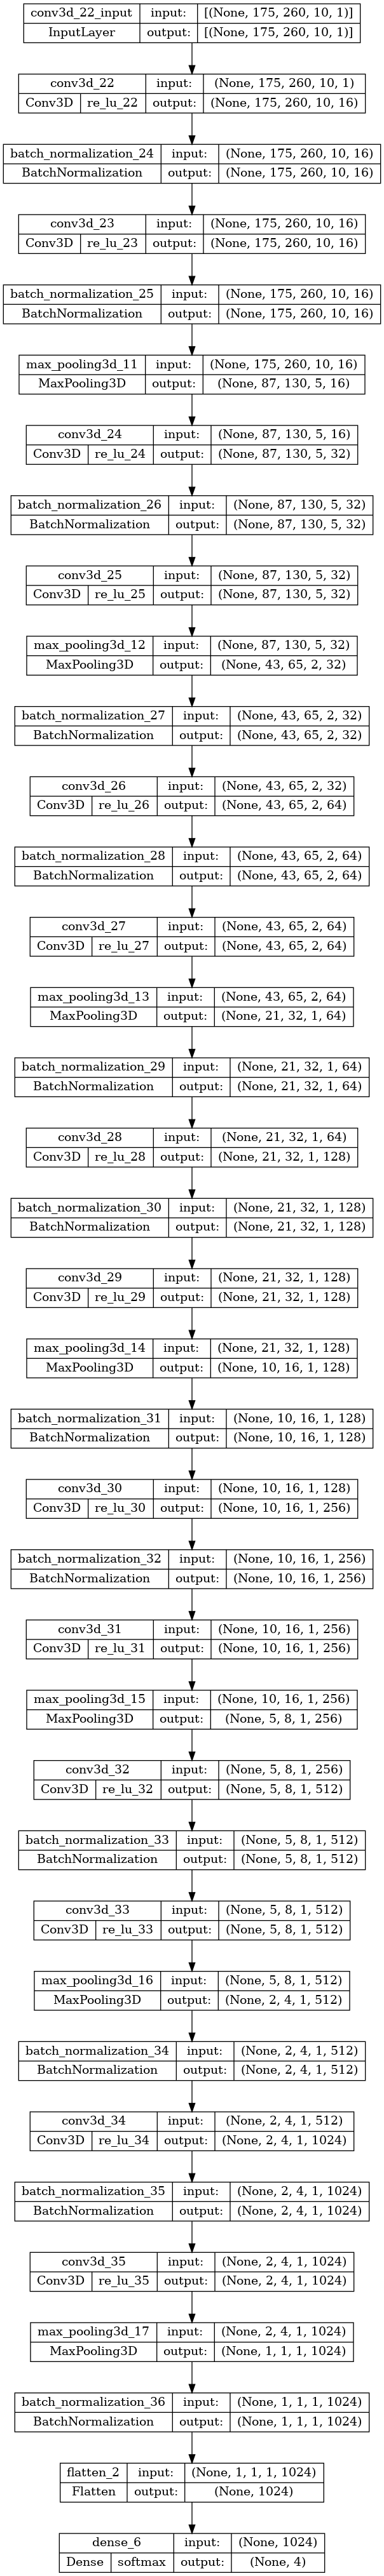

In [12]:
tf.keras.utils.plot_model(
    model_test1,
    show_shapes=True,
    show_layer_activations=True,
    to_file='model2.png',
)

In [16]:
model_test1.fit(train_x,
                train_y,
                batch_size=4,
                epochs=150,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[checkpoint_callback_accuracy, 
                           checkpoint_callback_precision, 
                           checkpoint_callback_auc1, 
                           checkpoint_callback_auc2],
               workers=1,
               use_multiprocessing=True)

Epoch 1/150
171/171 [==============================] - 54s 269ms/step - loss: 2.1676 - categorical_accuracy: 0.2617 - precision: 0.2450 - auc: 0.4989 - auc_1: 0.4976 - val_loss: 2.2834 - val_categorical_accuracy: 0.4318 - val_precision: 0.4615 - val_auc: 0.4730 - val_auc_1: 0.5359
Epoch 2/150
171/171 [==============================] - 42s 248ms/step - loss: 1.7164 - categorical_accuracy: 0.2558 - precision: 0.2572 - auc: 0.4929 - auc_1: 0.4878 - val_loss: 1.9259 - val_categorical_accuracy: 0.2045 - val_precision: 0.2143 - val_auc: 0.4940 - val_auc_1: 0.4503
Epoch 3/150
171/171 [==============================] - 42s 243ms/step - loss: 1.8105 - categorical_accuracy: 0.2749 - precision: 0.2722 - auc: 0.4956 - auc_1: 0.5009 - val_loss: 1.6540 - val_categorical_accuracy: 0.2500 - val_precision: 0.1667 - val_auc: 0.3978 - val_auc_1: 0.4463
Epoch 4/150
171/171 [==============================] - 41s 243ms/step - loss: 1.7183 - categorical_accuracy: 0.2734 - precision: 0.2768 - auc: 0.4996 - au

In [17]:
del val_x
del val_y
del train_x
del train_y

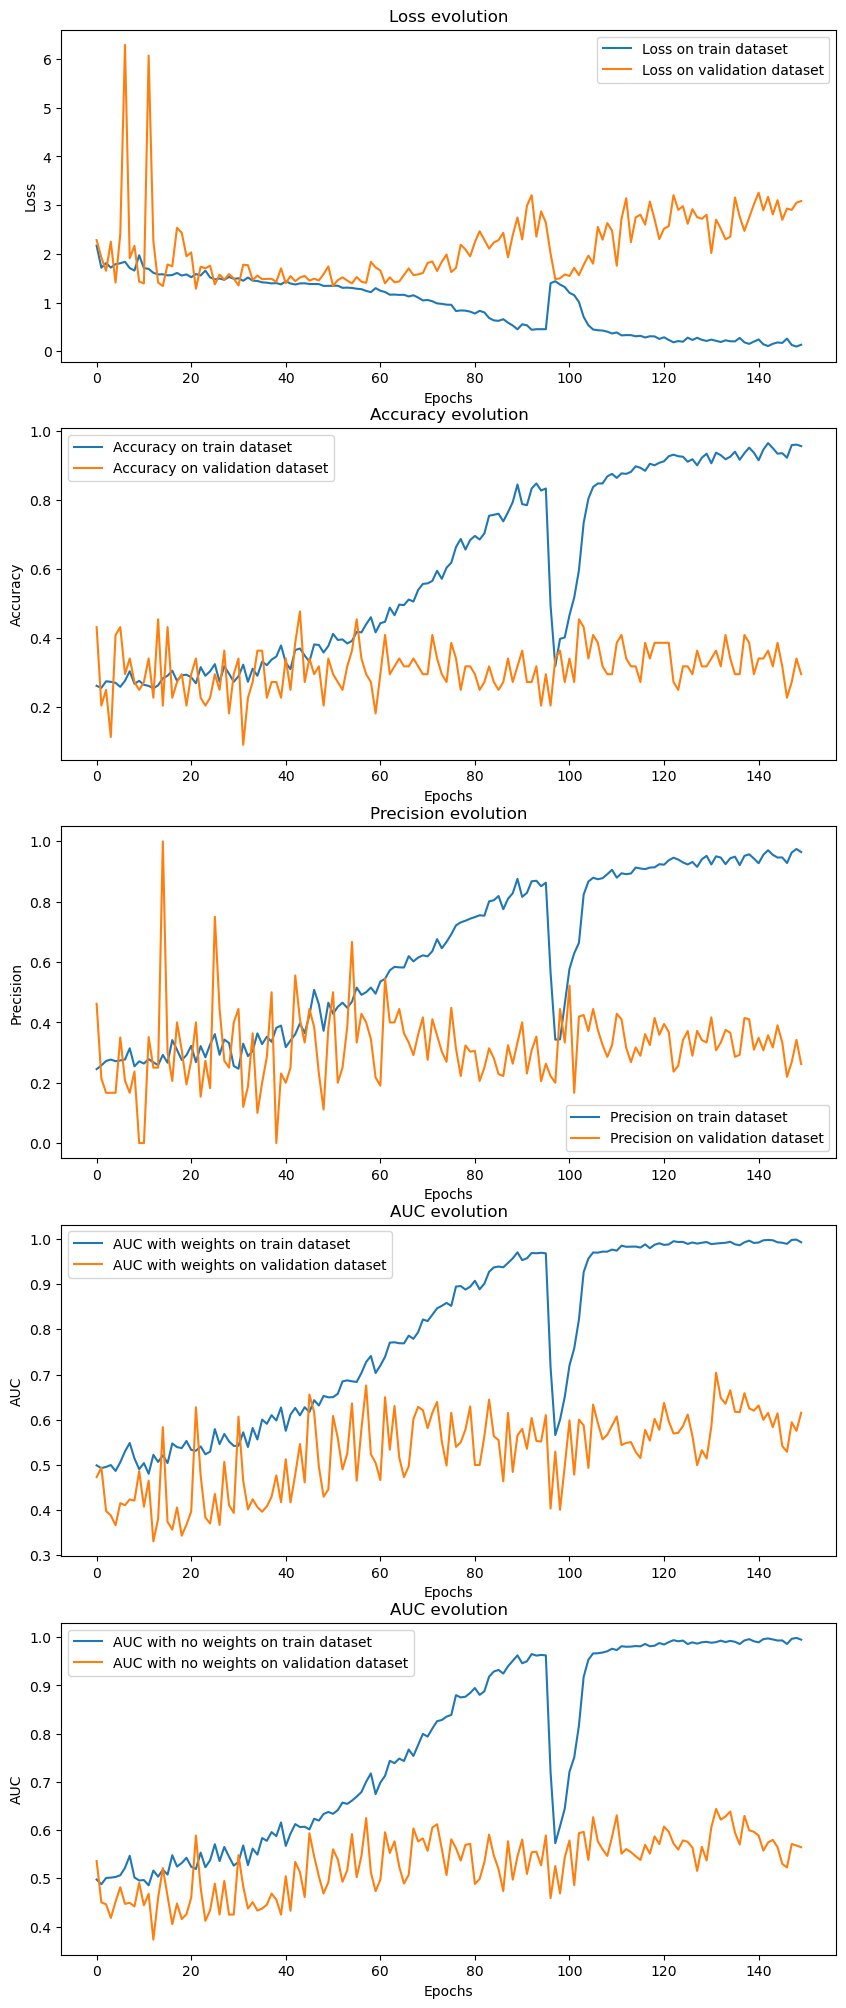

In [18]:
keys = list(model_test1.history.history.keys())
plt.figure(figsize=(10, 25))

plt.subplot(5, 1, 1)
plt.plot(model_test1.history.history[keys[0]], label='Training')
plt.plot(model_test1.history.history[keys[5]], label='Validation')
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss on train dataset', 'Loss on validation dataset'])

plt.subplot(5, 1, 2)
plt.plot(model_test1.history.history[keys[1]], label='Training')
plt.plot(model_test1.history.history[keys[6]], label='Validation')
plt.title('Accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy on train dataset', 'Accuracy on validation dataset'])

plt.subplot(5, 1, 3)
plt.plot(model_test1.history.history[keys[2]], label='Training')
plt.plot(model_test1.history.history[keys[7]], label='Validation')
plt.title('Precision evolution')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(['Precision on train dataset', 'Precision on validation dataset'])

plt.subplot(5, 1, 4)
plt.plot(model_test1.history.history[keys[3]], label='Training')
plt.plot(model_test1.history.history[keys[8]], label='Validation')
plt.title('AUC evolution')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['AUC with weights on train dataset', 'AUC with weights on validation dataset'])

plt.subplot(5, 1, 5)
plt.plot(model_test1.history.history[keys[4]], label='Training')
plt.plot(model_test1.history.history[keys[9]], label='Validation')
plt.title('AUC evolution')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['AUC with no weights on train dataset', 'AUC with no weights on validation dataset'])

68/68 [==============================] - 2s 23ms/step - loss: 3.0959 - categorical_accuracy: 0.3235 - precision: 0.3333 - auc: 0.5296 - auc_1: 0.5655


<AxesSubplot:>

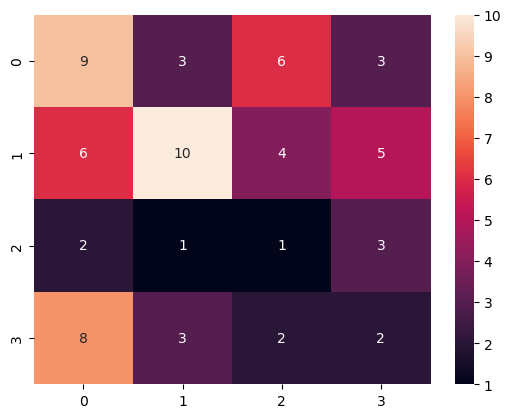

In [19]:
results_from_nn_test = []

for x in test_x:
  results_from_nn_test.append(model_test1.predict(np.array([x]), verbose=0))
model_test1.evaluate(test_x, test_y, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, test_y):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

68/68 [==============================] - 2s 25ms/step - loss: 1.7444 - categorical_accuracy: 0.3529 - precision: 0.3488 - auc: 0.4371 - auc_1: 0.4885


<AxesSubplot:>

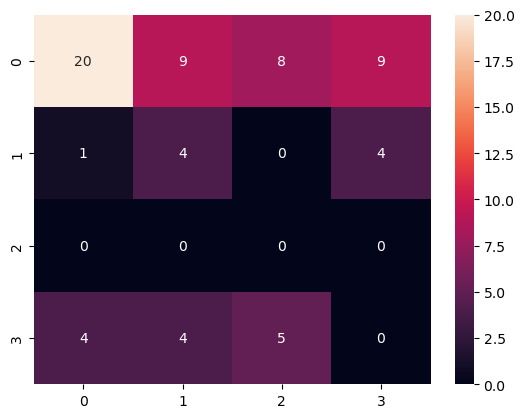

In [20]:
model_test1.load_weights('./models/accuracy/')

results_from_nn_test = []

for x in test_x:
  results_from_nn_test.append(model_test1.predict(np.array([x]), verbose=0))
model_test1.evaluate(test_x, test_y, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, test_y):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

68/68 [==============================] - 2s 25ms/step - loss: 1.6050 - categorical_accuracy: 0.1912 - precision: 0.0000e+00 - auc: 0.4304 - auc_1: 0.4491


<AxesSubplot:>

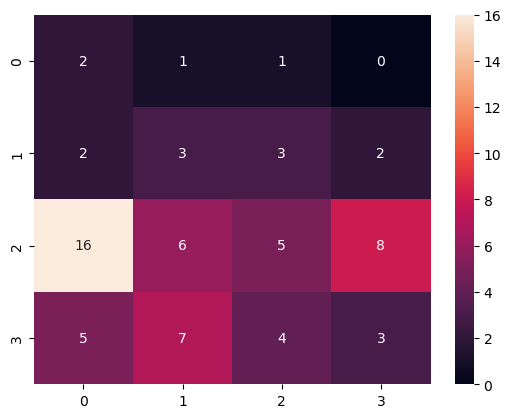

In [21]:
model_test1.load_weights('./models/precision/')

results_from_nn_test = []

for x in test_x:
  results_from_nn_test.append(model_test1.predict(np.array([x]), verbose=0))
model_test1.evaluate(test_x, test_y, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, test_y):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

68/68 [==============================] - 2s 23ms/step - loss: 3.1447 - categorical_accuracy: 0.3529 - precision: 0.3559 - auc: 0.4899 - auc_1: 0.5191


<AxesSubplot:>

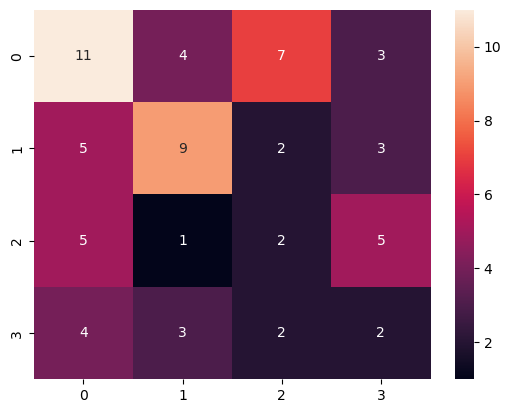

In [22]:
model_test1.load_weights('./models/auc1/')

results_from_nn_test = []

for x in test_x:
  results_from_nn_test.append(model_test1.predict(np.array([x]), verbose=0))
model_test1.evaluate(test_x, test_y, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, test_y):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

68/68 [==============================] - 2s 23ms/step - loss: 3.1447 - categorical_accuracy: 0.3529 - precision: 0.3559 - auc: 0.4899 - auc_1: 0.5191


<AxesSubplot:>

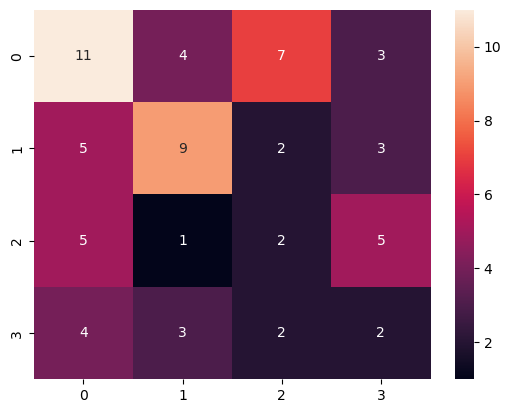

In [23]:
model_test1.load_weights('./models/auc2/')

results_from_nn_test = []

for x in test_x:
  results_from_nn_test.append(model_test1.predict(np.array([x]), verbose=0))
model_test1.evaluate(test_x, test_y, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, test_y):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

In [7]:
model_test1 = tf.keras.Sequential()

model_test1.add(tf.keras.layers.Conv3D(input_shape=(175,260,10,1), filters=32, kernel_size=(8,12,5), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=32, kernel_size=(3,3,3), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.MaxPooling3D(pool_size=(3,3,2)))
model_test1.add(tf.keras.layers.Conv3D(filters=64, kernel_size=(3,3,3), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=64, kernel_size=(3,3,3), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.MaxPooling3D(pool_size=(3,3,2)))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=128, kernel_size=(3,3,2), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=128, kernel_size=(3,3,2), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=256, kernel_size=(3,3,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Conv3D(filters=256, kernel_size=(3,3,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
model_test1.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,1)))
model_test1.add(tf.keras.layers.Flatten())
model_test1.add(tf.keras.layers.Dense(4096, activation=('selu')))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Dropout(0.5))
model_test1.add(tf.keras.layers.Dense(2048, activation=('selu')))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Dropout(0.5))
model_test1.add(tf.keras.layers.Dense(1024, activation=('selu')))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Dropout(0.5))
model_test1.add(tf.keras.layers.Dense(512, activation=('selu')))
model_test1.add(tf.keras.layers.BatchNormalization())
model_test1.add(tf.keras.layers.Dense(4, activation=('softmax')))

model_test1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, amsgrad=True), 
                    loss='categorical_crossentropy', 
                    metrics=[tf.keras.metrics.CategoricalAccuracy(), 
                             tf.keras.metrics.Precision(),
                             tf.keras.metrics.AUC(multi_label=True, num_labels=4, label_weights=[0.25, 0.5, 0.25, 1]),
                             tf.keras.metrics.AUC(multi_label=True, num_labels=4)])

model_test1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_14 (Conv3D)          (None, 175, 260, 10, 32)  15392     
                                                                 
 batch_normalization_13 (Bat  (None, 175, 260, 10, 32)  128      
 chNormalization)                                                
                                                                 
 conv3d_15 (Conv3D)          (None, 175, 260, 10, 32)  27680     
                                                                 
 batch_normalization_14 (Bat  (None, 175, 260, 10, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 58, 86, 5, 32)    0         
 3D)                                                             
                                                      

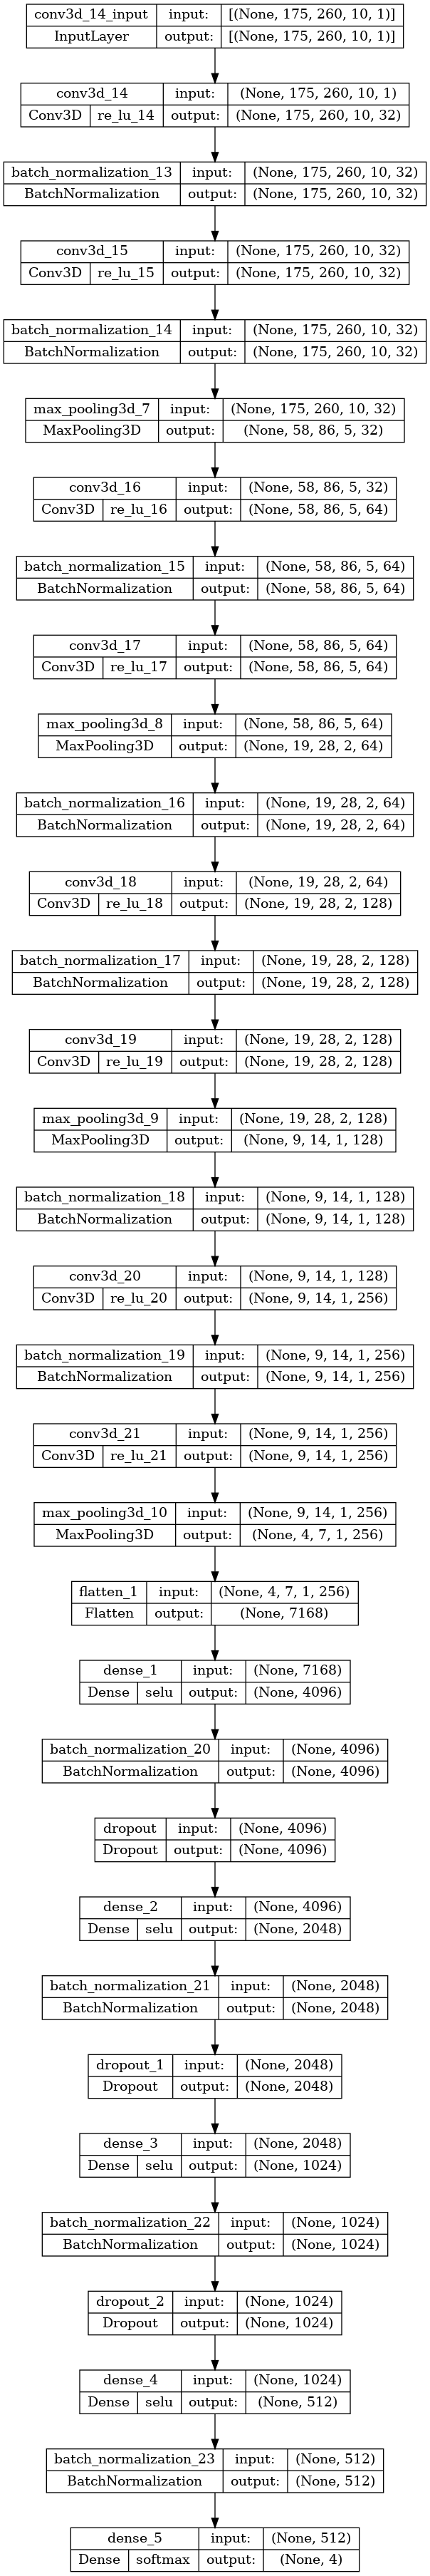

In [8]:
tf.keras.utils.plot_model(
    model_test1,
    show_shapes=True,
    show_layer_activations=True
)

In [13]:
model_test1.fit(train_x,
                train_y,
                batch_size=4,
                epochs=150,
                shuffle=True,
                validation_data=(val_x, val_y),
                callbacks=[checkpoint_callback_accuracy, 
                           checkpoint_callback_precision, 
                           checkpoint_callback_auc1, 
                           checkpoint_callback_auc2],
               workers=1,
               use_multiprocessing=True)

Epoch 1/150
171/171 [==============================] - 74s 375ms/step - loss: 2.1208 - categorical_accuracy: 0.2675 - precision: 0.2553 - auc: 0.5115 - auc_1: 0.5096 - val_loss: 1.8351 - val_categorical_accuracy: 0.2500 - val_precision: 0.2667 - val_auc: 0.4211 - val_auc_1: 0.4581
Epoch 2/150
171/171 [==============================] - 54s 317ms/step - loss: 1.6945 - categorical_accuracy: 0.2515 - precision: 0.2340 - auc: 0.5112 - auc_1: 0.4947 - val_loss: 1.6652 - val_categorical_accuracy: 0.2273 - val_precision: 0.2500 - val_auc: 0.5673 - val_auc_1: 0.5278
Epoch 3/150
171/171 [==============================] - 58s 340ms/step - loss: 1.6486 - categorical_accuracy: 0.2485 - precision: 0.3012 - auc: 0.5069 - auc_1: 0.5077 - val_loss: 1.3884 - val_categorical_accuracy: 0.3636 - val_precision: 0.2727 - val_auc: 0.6221 - val_auc_1: 0.5771
Epoch 4/150
171/171 [==============================] - 52s 304ms/step - loss: 1.5652 - categorical_accuracy: 0.2544 - precision: 0.3054 - auc: 0.4878 - au

In [14]:
del val_x
del val_y
del train_x
del train_y

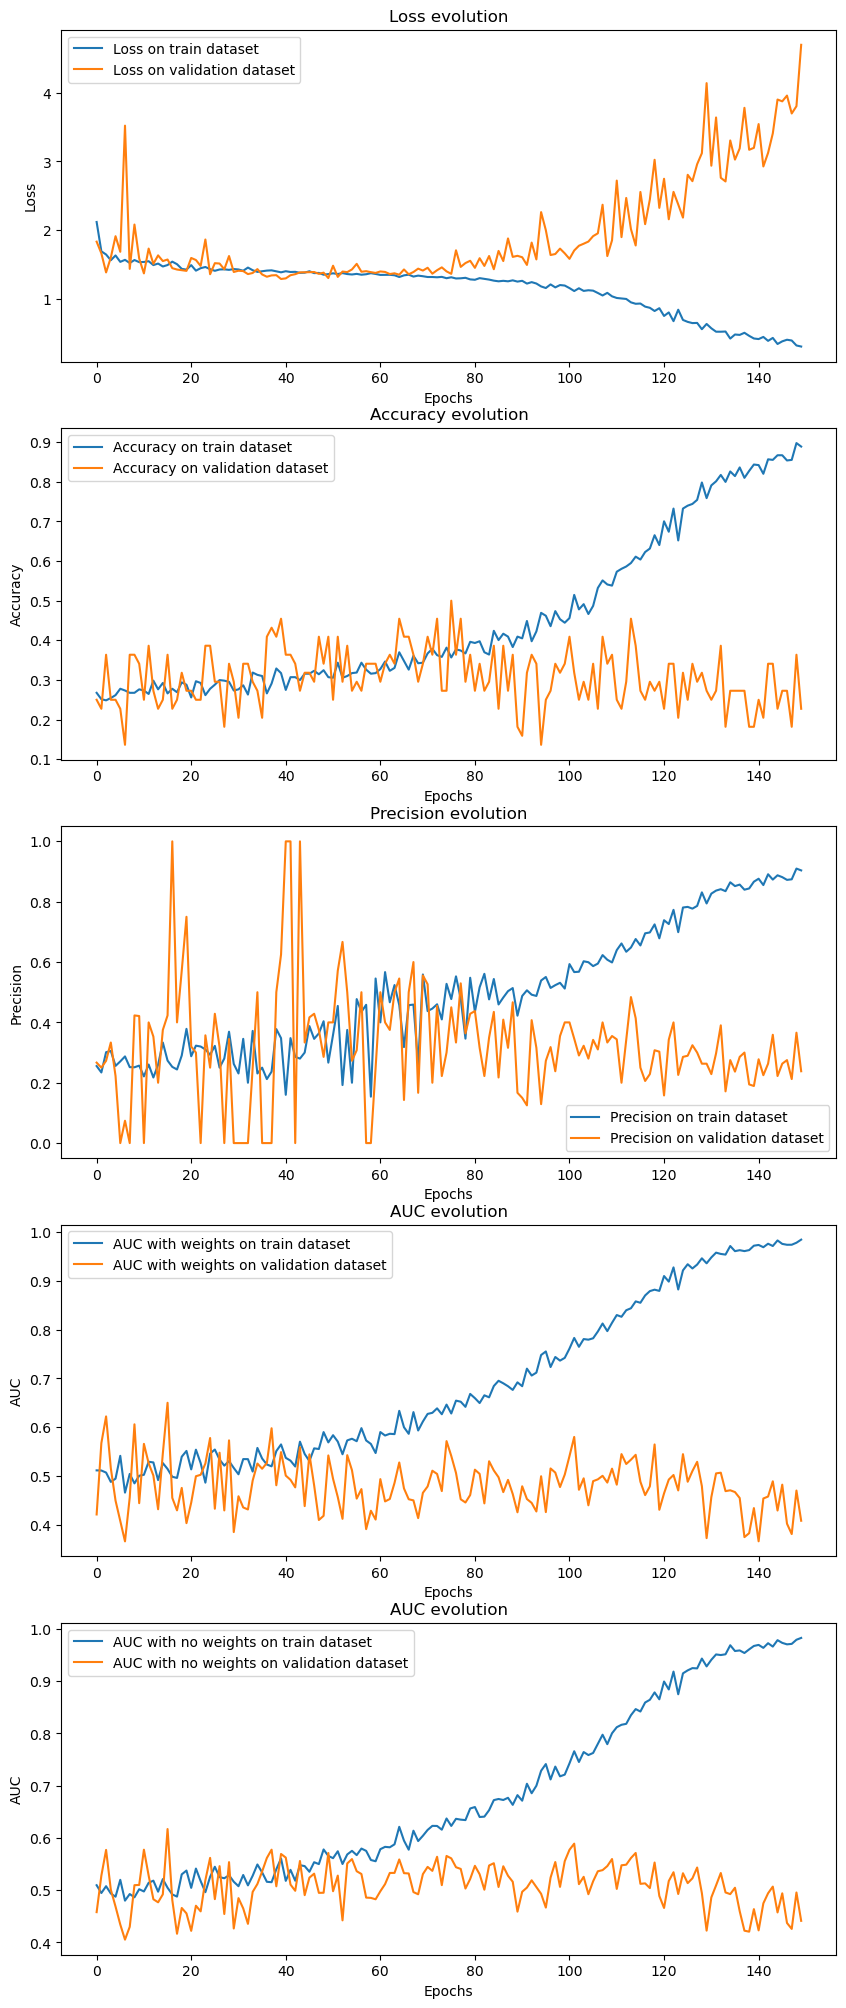

In [15]:
keys = list(model_test1.history.history.keys())
plt.figure(figsize=(10, 25))

plt.subplot(5, 1, 1)
plt.plot(model_test1.history.history[keys[0]], label='Training')
plt.plot(model_test1.history.history[keys[5]], label='Validation')
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss on train dataset', 'Loss on validation dataset'])

plt.subplot(5, 1, 2)
plt.plot(model_test1.history.history[keys[1]], label='Training')
plt.plot(model_test1.history.history[keys[6]], label='Validation')
plt.title('Accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy on train dataset', 'Accuracy on validation dataset'])

plt.subplot(5, 1, 3)
plt.plot(model_test1.history.history[keys[2]], label='Training')
plt.plot(model_test1.history.history[keys[7]], label='Validation')
plt.title('Precision evolution')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(['Precision on train dataset', 'Precision on validation dataset'])

plt.subplot(5, 1, 4)
plt.plot(model_test1.history.history[keys[3]], label='Training')
plt.plot(model_test1.history.history[keys[8]], label='Validation')
plt.title('AUC evolution')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['AUC with weights on train dataset', 'AUC with weights on validation dataset'])

plt.subplot(5, 1, 5)
plt.plot(model_test1.history.history[keys[4]], label='Training')
plt.plot(model_test1.history.history[keys[9]], label='Validation')
plt.title('AUC evolution')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['AUC with no weights on train dataset', 'AUC with no weights on validation dataset'])

68/68 [==============================] - 3s 26ms/step - loss: 3.1955 - categorical_accuracy: 0.2794 - precision: 0.2812 - auc: 0.4832 - auc_1: 0.5054


<AxesSubplot:>

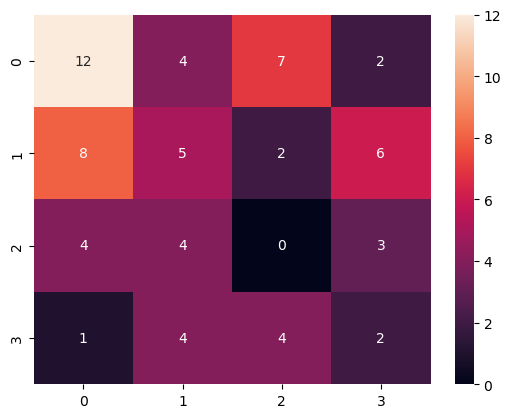

In [16]:
results_from_nn_test = []

for x in test_x:
  results_from_nn_test.append(model_test1.predict(np.array([x]), verbose=0))
model_test1.evaluate(test_x, test_y, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, test_y):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

68/68 [==============================] - 2s 26ms/step - loss: 1.4103 - categorical_accuracy: 0.3235 - precision: 0.4848 - auc: 0.5452 - auc_1: 0.5783


<AxesSubplot:>

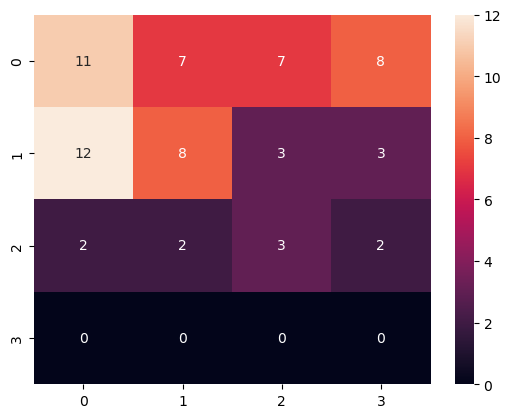

In [17]:
model_test1.load_weights('./models/accuracy/')

results_from_nn_test = []

for x in test_x:
  results_from_nn_test.append(model_test1.predict(np.array([x]), verbose=0))
model_test1.evaluate(test_x, test_y, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, test_y):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

68/68 [==============================] - 2s 27ms/step - loss: 1.5018 - categorical_accuracy: 0.1618 - precision: 0.0000e+00 - auc: 0.4336 - auc_1: 0.4379


<AxesSubplot:>

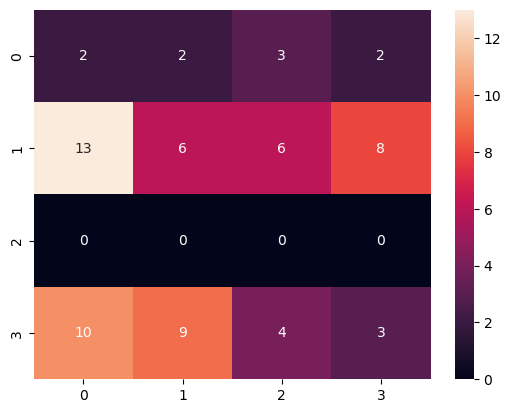

In [18]:
model_test1.load_weights('./models/precision/')

results_from_nn_test = []

for x in test_x:
  results_from_nn_test.append(model_test1.predict(np.array([x]), verbose=0))
model_test1.evaluate(test_x, test_y, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, test_y):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

68/68 [==============================] - 2s 28ms/step - loss: 1.7286 - categorical_accuracy: 0.3676 - precision: 0.4151 - auc: 0.6172 - auc_1: 0.5823


<AxesSubplot:>

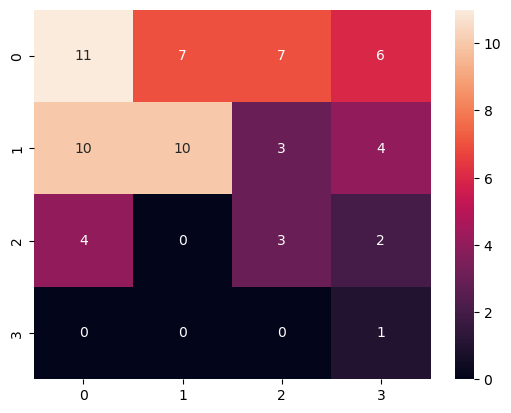

In [19]:
model_test1.load_weights('./models/auc1/')

results_from_nn_test = []

for x in test_x:
  results_from_nn_test.append(model_test1.predict(np.array([x]), verbose=0))
model_test1.evaluate(test_x, test_y, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, test_y):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

68/68 [==============================] - 2s 26ms/step - loss: 1.7286 - categorical_accuracy: 0.3676 - precision: 0.4151 - auc: 0.6172 - auc_1: 0.5823


<AxesSubplot:>

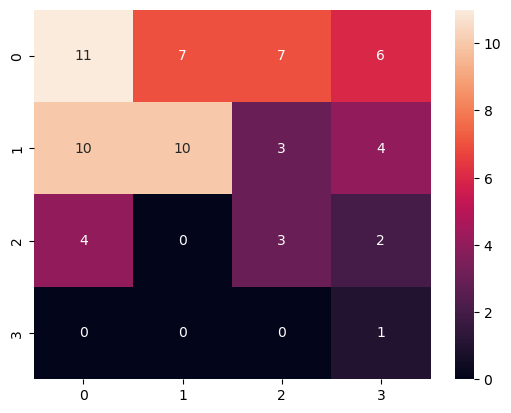

In [20]:
model_test1.load_weights('./models/auc2/')

results_from_nn_test = []

for x in test_x:
  results_from_nn_test.append(model_test1.predict(np.array([x]), verbose=0))
model_test1.evaluate(test_x, test_y, batch_size=1)

confusion_matrix_test = [[0 for _ in range(4)] for _ in range(4)]

for pred, res in zip(results_from_nn_test, test_y):
  pred = np.argmax(pred[0])
  res = np.argmax(res)
  confusion_matrix_test[pred][res] += 1

seaborn.heatmap(confusion_matrix_test, annot=True)

In [43]:
FCN = tf.keras.Sequential()

FCN.add(tf.keras.layers.Conv3D(input_shape=(290,400,10,1), filters=16, kernel_size=(6,8,5), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=16, kernel_size=(3,4,5), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)))
FCN.add(tf.keras.layers.Conv3D(filters=32, kernel_size=(3,4,3), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=32, kernel_size=(3,4,3), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=64, kernel_size=(3,4,2), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=64, kernel_size=(3,4,2), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=128, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=128, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=128, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,1)))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=256, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=256, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=256, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,1)))
FCN.add(tf.keras.layers.Conv3D(filters=512, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=512, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=512, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,1)))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=1024, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=1024, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=1024, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=1024, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.MaxPooling3D(pool_size=(2,2,1)))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=1024, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=1024, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=1024, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=1024, kernel_size=(3,4,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()))
FCN.add(tf.keras.layers.MaxPooling3D(pool_size=(2,3,1)))
FCN.add(tf.keras.layers.BatchNormalization())
FCN.add(tf.keras.layers.Conv3D(filters=4, kernel_size=(1,1,1), use_bias=True, padding='same', activation=tf.keras.layers.Softmax()))
FCN.add(tf.keras.layers.Flatten())

In [44]:
FCN.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_268 (Conv3D)         (None, 290, 400, 10, 16)  3856      
                                                                 
 batch_normalization_244 (Ba  (None, 290, 400, 10, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_269 (Conv3D)         (None, 290, 400, 10, 16)  15376     
                                                                 
 batch_normalization_245 (Ba  (None, 290, 400, 10, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_117 (MaxPooli  (None, 145, 200, 5, 16)  0         
 ng3D)                                                           
                                                     

In [39]:
test = np.random.random((10, 290, 400, 10, 1))

In [40]:
FCN.predict(test)

1/1 [==============================] - 26s 26s/step


array([[0.09044877, 0.04613654, 0.49669558, 0.36671913],
       [0.09528582, 0.04790781, 0.50129294, 0.3555135 ],
       [0.08589661, 0.04710944, 0.5168499 , 0.350144  ],
       [0.08843164, 0.04563227, 0.51871717, 0.34721896],
       [0.09331982, 0.04755562, 0.50461704, 0.35450763],
       [0.08964111, 0.04657619, 0.51903653, 0.3447462 ],
       [0.08628758, 0.0439581 , 0.50970995, 0.3600443 ],
       [0.08758397, 0.04823456, 0.5164885 , 0.34769306],
       [0.0878882 , 0.04883042, 0.51529163, 0.34798974],
       [0.08371256, 0.04540911, 0.5118999 , 0.35897848]], dtype=float32)

In [25]:
model = tf.keras.Sequential([tf.keras.layers.Conv3D(input_shape=(290,400,15,1), filters=16, kernel_size=(6,8,5), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)),
                             tf.keras.layers.Conv3D(filters=32, kernel_size=(6,8,3), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv3D(filters=32, kernel_size=(6,8,3), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv3D(filters=64, kernel_size=(6,8,2), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv3D(filters=64, kernel_size=(6,8,2), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.MaxPooling3D(pool_size=(2,2,2)),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv3D(filters=128, kernel_size=(6,8,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv3D(filters=128, kernel_size=(6,8,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.MaxPooling3D(pool_size=(2,2,1)),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv3D(filters=256, kernel_size=(6,8,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv3D(filters=256, kernel_size=(6,8,1), use_bias=True, padding='same', activation=tf.keras.layers.ReLU(), kernel_initializer=tf.keras.initializers.HeNormal()),
                             tf.keras.layers.MaxPooling3D(pool_size=(3,4,1)),
                             tf.keras.layers.BatchNormalization()])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 290, 400, 15, 16)  3856      
                                                                 
 batch_normalization_9 (Batc  (None, 290, 400, 15, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 145, 200, 7, 16)  0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 145, 200, 7, 32)   73760     
                                                                 
 batch_normalization_10 (Bat  (None, 145, 200, 7, 32)  128       
 chNormalization)                                                
                                                      